In [1]:
from imports import *
from periodogram import compute_LSperiodogram
from read_data import *
from bgls import bgls
from rvmodel import get_rv1
from priors import *
from autocorrDFM import *
%matplotlib inline


Bad key "xtick.labeltop" on line 358 in
/Users/ryancloutier/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# get data
bjd, rv, erv, fwhm, bis, Halpha, eHalpha, Hbeta, eHbeta, Hgamma, eHgamma, NaD, eNaD, Sindex, eSindex = read_HARPS()
#g =  [5 48 83] 3.69 days
#g = [] 7.45 days
print bjd.size

-5678.16
114


## visualize data

<Container object of 3 artists>

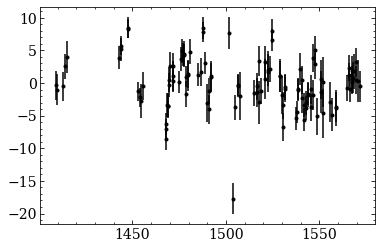

In [3]:
# plot RVs
t0 = 2457000
plt.errorbar(bjd-t0, rv, erv, fmt='k.')

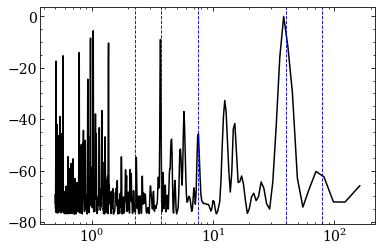

In [4]:
per,pwr = bgls(bjd, rv, erv, plow=.5, phigh=bjd.max()-bjd.min(), n_steps=1e3)
plt.plot(per, np.log(pwr), 'k-')
plt.xscale('log')
Ps = [2.25,3.69,7.45,80,40]
for p in Ps:
    plt.axvline(p, ls='--', lw=.9, color='b')

## run LOOCV on the remaining planet periods

In [5]:
def run_loocv(P, bjd, rv, erv, mu, kepmodel):
    '''Investigate the strength of a particular periodicity by omitting individual measurements.'''
    assert bjd.size == rv.size
    assert bjd.size == erv.size
    assert bjd.size == mu.size
    assert bjd.size == kepmodel.size
    
    prob_P = np.zeros(bjd.size)
    for i in range(bjd.size):
        # compute BGLS
        bjd_red = np.delete(bjd, i)
        rv_red = np.delete(rv-mu-kepmodel, i)
        erv_red = np.delete(erv, i)
        per,prob = bgls(bjd_red, rv_red, erv_red, plow=.5, phigh=2e2, n_steps=1e3)
        
        # what is the probability of the period of interest?
        g = np.isclose(per, P, rtol=.01)
        prob_P[i] = prob[g].max()
        
    return prob_P

In [6]:
# run loocv
print Ps
prob_P1 = run_loocv(Ps[1], bjd, rv, erv, np.zeros(bjd.size), np.zeros(bjd.size))
#prob_P2 = run_loocv(Ps[2], bjd, rv, erv, np.zeros(bjd.size), np.zeros(bjd.size))

[2.25, 3.69, 7.45, 80, 40]


[48 83]
0.0020591960506587013
0.002229541835375252
0.043451593619121445


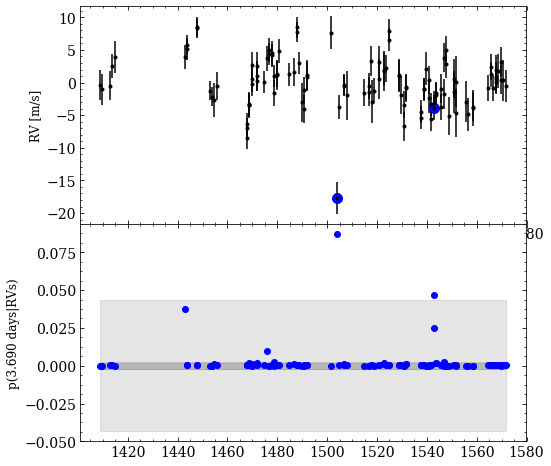

In [13]:
# plot loocv results
t0 = 2457000#bjd.min()
cols = ['b','r','g']

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.errorbar(bjd-t0, rv, erv, fmt='k.')
b1 = (abs(prob_P1-prob_P1.mean()) > np.percentile(abs(prob_P1-prob_P1.mean()), 99))
#b2 = (abs(prob_P2-prob_P2.mean()) > np.percentile(abs(prob_P2-prob_P2.mean()), 99))
print np.where(b1)[0]#, np.where(b2)[0], '\n'
plt.plot(bjd[b1]-t0, rv[b1], 'o', c=cols[0], ms=10)
#plt.plot(bjd[b2]-t0, rv[b2], 'o', c=cols[1], ms=10)
plt.ylabel('RV [m/s]', fontsize=12)

plt.subplot(212)
plt.plot(bjd-t0, prob_P1, 'o', color=cols[0])
for i in [68,95,99]:
    v = np.percentile(abs(prob_P1-prob_P1.mean()), i)
    print v
    plt.fill_between(bjd-t0, v, -v, alpha=.1, color='k')
plt.ylabel('p(%.3f days|RVs)'%Ps[1], fontsize=12)

#plt.subplot(313)
#plt.plot(bjd-t0, prob_P2, '.', color=cols[1])
#for i in [68,95,99]:
#    v = np.percentile(abs(prob_P2-prob_P2.mean()), i)
#    print v
#    plt.fill_between(bjd-t0, v, -v, alpha=.1, color='k')
#plt.xlabel('Time of omitted measurement\n[BJD - %i]'%t0, fontsize=12)
#plt.ylabel('p(%.3f days|RVs)'%Ps[2], fontsize=12)

plt.subplots_adjust(hspace=0)
plt.savefig('/Users/ryancloutier/Research/TOI_175/plots/loocv_3d69.png')

## plot periodograms

In [ ]:
# plot periograms
Prot = 80
Ps = [2.25,3.69,7.45,Prot,Prot/2.]
xs = [bjd, bjd, bjd, bjd, bjd, bjd, bjd, bjd, bjd]
ys = [rv, bjd, fwhm, bis, Halpha, Hbeta, Hgamma, NaD, Sindex]
eys = [erv, erv, np.ones(bjd.size), np.ones(bjd.size), eHalpha, eHbeta, eHgamma, eNaD, eSindex]
labels = ['RV','WF','FWHM','BIS','Halpha','Hbeta','Hgamma','NaD','Sindex']
for i in range(len(xs)):
    #per,pwr = bgls(xs[i], ys[i], eys[i], plow=.5, phigh=bjd.max()-bjd.min(), n_steps=1e3)
    per,_,pwr = compute_LSperiodogram(xs[i], ys[i], eys[i], plims=(.5,bjd.max()-bjd.min()))
    plt.figure(i, figsize=(8,4))
    plt.plot(per, pwr, 'k-'), plt.xscale('log')
    plt.ylabel('BGLS %s'%labels[i], fontsize=12), plt.xlabel('Period [days]', fontsize=12)
    for p in Ps:
        plt.axvline(p, ls='--', lw=.9, color='b')